In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
import JLD
using Colors
import FileIO
import PyPlot

In [2]:
function db_scale_img(img , min , max)
    log_img = (10*log10.(img).-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end


function db_scale_img_diff(img1,img2 , min , max)
    log_img = 10*log10.(img1).-10*log10.(img2)
    log_img = (log_img.-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end

function scale_img(img , min , max)
    scale_img = (img.-min)./(max-min)
    scale_img[scale_img.>1] .= 0.999
    scale_img[scale_img.<0] .= 0.001
    return scale_img
end


function scale_img(img)
    min = minimum(reshape(img,:))
    max = maximum(reshape(img,:))
    return scale_img(img , min , max)
end

min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

min_r = -10
max_r = 1;

min_h = -10
max_h = 100;

function add_mask(img,mask,color=(1,0,0))
    color = Colors.RGB{Float32}(color...)
    img_cop = copy(img)
    img_cop[mask] .= color
    return img_cop
end

function pretty_img(bands,min,max,k=1/1.4)
    pre = db_scale_img((bands[2] .+bands[3])./2,min,max) 
    co = db_scale_img(bands[1],min,max) 
    co = co.^k
    pre = pre.^k
    return Colors.RGB{Float32}.(pre,co,co);
end





pretty_img (generic function with 2 methods)

In [3]:
folder = "/home/data/simon/processed/66_fyn_winter2020/vejle" # desend

dem_nan = 40

co_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")
pre_gamma = JLD.load(joinpath(folder,"23VV_coher.jld"),"data")

VV_paths = [joinpath(folder,string(i)*"VV_itens.jld") for i=1:3]
VV = [JLD.load(path,"data") for path in VV_paths]
VH_paths = [joinpath(folder,string(i)*"VH_itens.jld") for i=1:3]
VH = [JLD.load(path,"data") for path in VH_paths];
heights = JLD.load(joinpath(folder,"heights.jld"),"data").-dem_nan;

line_sample = JLD.load(joinpath(folder,"line_sample.jld"))
samples = collect(line_sample["samples"]) #[1:7:end]
lines = collect(line_sample["lines"]) #[1:2:end]
lut = JLD.load(joinpath(folder,"21_lut.jld"),"data");

In [4]:
#### Permant water

In [5]:
 folder = "/home/data/simon/result/segmenting/0Vejle"

"/home/data/simon/result/segmenting/0Vejle"

In [6]:
permant_water_VH = sum([10 .*log10.(band) .< -26 for band in VH]);

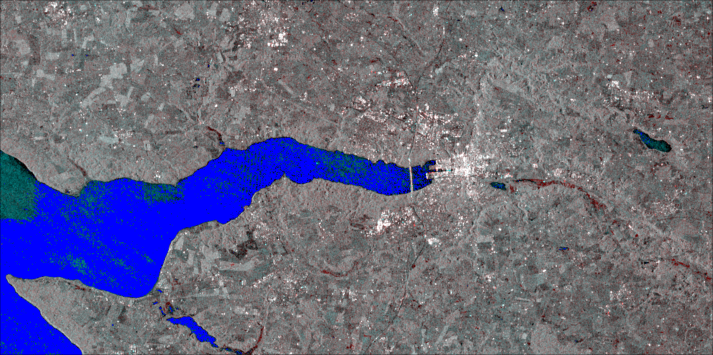

In [7]:
img = pretty_img(VV,min_vv,max_vv);
img = add_mask(img, 2.5 .<permant_water_VH ,(0,0,1))

In [8]:
permant_water_VV = sum([10 .*log10.(band) .< -18 for band in VV]);

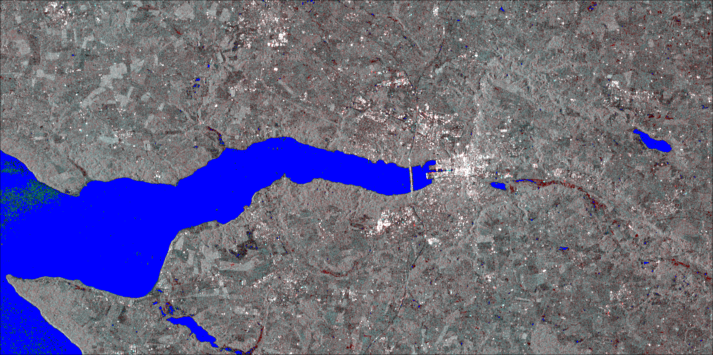

In [9]:
img = pretty_img(VV,min_vv,max_vv);
img = add_mask(img, 1.5 .<permant_water_VV ,(0,0,1))

In [10]:
permanent_water = (1.5 .<permant_water_VV) .| (1.5 .<permant_water_VH);

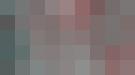

In [11]:
img = pretty_img(VV,min_vv,max_vv);
Img = add_mask(img, permanent_water,(0,0,1))[1:5,798:806]

In [12]:
import PyCall
skimage_morph = PyCall.pyimport("skimage.morphology");
skimage_meas = PyCall.pyimport("skimage.measure");
ndimage = PyCall.pyimport("scipy.ndimage")

PyObject <module 'scipy.ndimage' from '/home/data/simon/anaconda3/envs/sentinel/lib/python3.8/site-packages/scipy/ndimage/__init__.py'>

In [13]:
kernel = ones(2,2)

water_morph = skimage_morph.binary_closing(permanent_water,kernel)
water_morph = skimage_morph.binary_opening(water_morph,kernel);

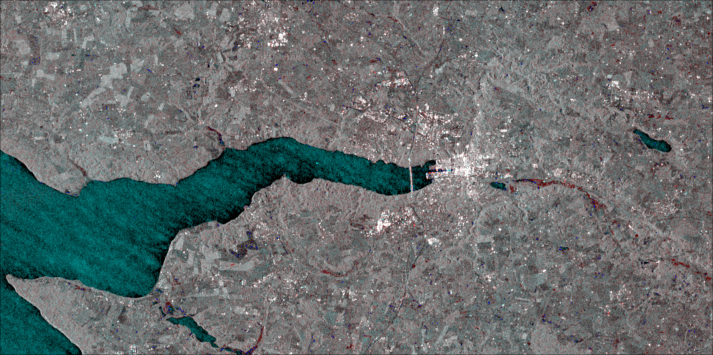

In [14]:
img = pretty_img(VV,min_vv,max_vv);
img = add_mask(img, water_morph .!= permanent_water,(0,0,1))

In [15]:
water_contours = skimage_meas.find_contours(convert.(Float32,water_morph), 0.5);
#water_polygons = [skimage_meas.approximate_polygon(elem, 2) for elem in water_contours];

### Get lat lon for the contours

In [16]:
contours_coords =  deepcopy(water_contours)

offset_line = line_sample["lines"].ref.hi
step_line = line_sample["lines"].step.hi

offset_sample = line_sample["samples"].ref.hi
step_sample = line_sample["samples"].step.hi

lut_dims = (length(lut["master_line"]),length(lut["master_sample"]))
lat_grid = reshape(lut["latitude"],lut_dims)
lon_grid = reshape(lut["longitude"],lut_dims);

for i in 1:length(water_contours)
    ## contours in line and sample
    index_1 = water_contours[i][:,1] .*step_line .+offset_line
    index_2 = water_contours[i][:,2] .*step_sample .+offset_sample
    ## countours in row, coulmn of lut grid
    index_1 = (index_1 .- lut["master_line"][1])./(lut["master_line"][2]-lut["master_line"][1])
    index_2 = (index_2 .- lut["master_sample"][1])./(lut["master_sample"][2]-lut["master_sample"][1])
    
    contours_coords[i][:,1] = ndimage.map_coordinates(lat_grid,[index_1,index_2])
    contours_coords[i][:,2] = ndimage.map_coordinates(lon_grid,[index_1,index_2])
end


In [17]:
shapely_geometry = PyCall.pyimport("shapely.geometry")

PyObject <module 'shapely.geometry' from '/home/data/simon/anaconda3/envs/sentinel/lib/python3.8/site-packages/shapely/geometry/__init__.py'>

In [18]:
polygons = [[(elem[i,2],elem[i,1]) for i in 1:size(elem)[1]]  for elem in contours_coords]
polygons = [shapely_geometry.Polygon(elem) for elem in polygons];

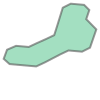

In [19]:
polygons[7]

In [20]:
water_type = [0 for i in 1:length(polygons)]
name = ["permant water" for i in 1:length(polygons)]
number = collect(1:length(polygons));
pandas_dict = Dict("Number" => number, "Name" => name, 
                "Water type"=> water_type, "Polygon"=> polygons)

Dict{String,Array{T,1} where T} with 4 entries:
  "Water type" => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, …
  "Polygon"    => PyCall.PyObject[PyObject <shapely.geometry.polygon.Polygon ob…
  "Number"     => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  85, 86, 87, 88, 89, 90, 91…
  "Name"       => ["permant water", "permant water", "permant water", "permant …

In [21]:
pandas = PyCall.pyimport("pandas")
geopandas = PyCall.pyimport("geopandas")

PyObject <module 'geopandas' from '/home/data/simon/anaconda3/envs/sentinel/lib/python3.8/site-packages/geopandas/__init__.py'>

In [22]:
df = pandas.DataFrame(pandas_dict)
gdf = geopandas.GeoDataFrame(df, geometry="Polygon")
gdf.crs = Dict("init" => "EPSG:4326")

Dict{String,String} with 1 entry:
  "init" => "EPSG:4326"

In [23]:
gdf.to_file(joinpath(folder,"water_test.shp"))